# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


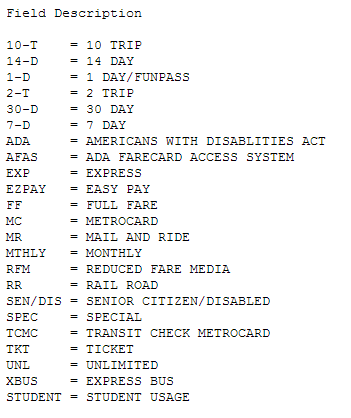

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
mta = np.load("MTA_Fare.npy")

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

Text(0,0.5,'swipes')

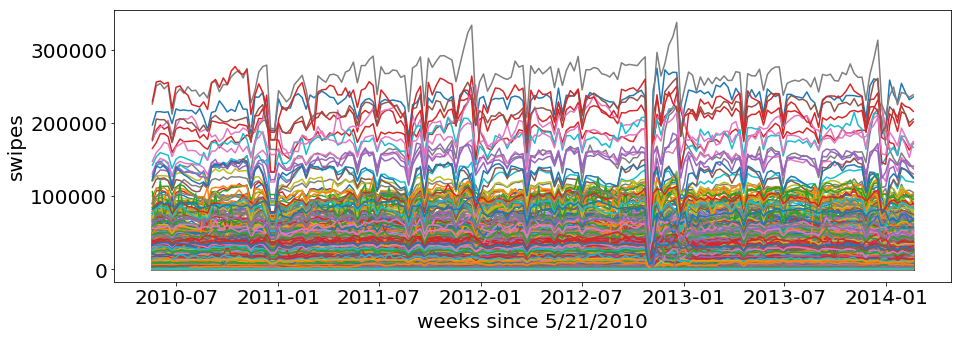

In [5]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

weekrange = pd.date_range(start='05/19/2010', end='02/19/2014', periods=194) 
# create a date range  to enhance the visibility

pl.subplots(figsize=(15,5))
#i = 0
for i in mta:
    for n in i:
        pl.plot(weekrange, n)
pl.xlabel('weeks since 5/21/2010')
pl.ylabel('swipes')

#### Figure 1: time series for all ride types and all stations in natural space

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0,0.5,'swipes (log10)')

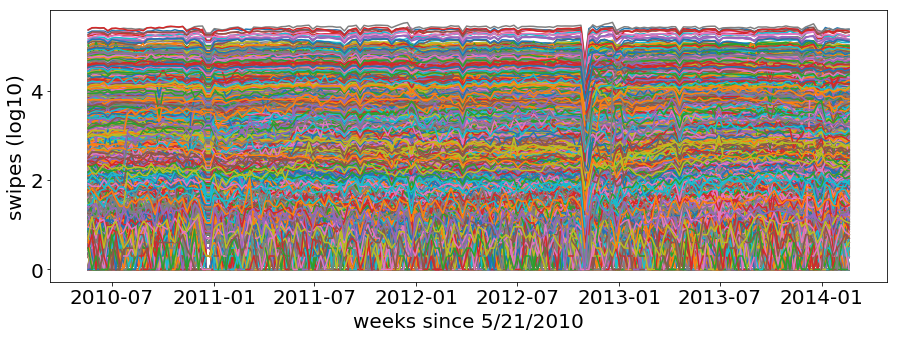

In [6]:
pl.subplots(figsize=(15,5))
#i = 0
for i in mta:
    for n in i:
        pl.plot(weekrange, np.log10(n))
        
pl.xlabel('weeks since 5/21/2010')
pl.ylabel('swipes (log10)')

#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [7]:
mta = mta.astype('float')
mta[mta==-1]=numpy.nan
#ridership[ridership==-1]=numpy.nan

In [8]:
swipesperday = np.nansum((np.nansum(mta, axis = 0)), axis = 0)
sigma3 = swipesperday.mean() - 3 * swipesperday.std() 
weekrange[np.where(swipesperday < sigma3)]

DatetimeIndex(['2012-10-30 17:02:10.569948160'], dtype='datetime64[ns]', freq=None)

### Event: According to the date, Hurricane Sandy arrived during that week which significantly decreased mta rides. 

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [9]:
#create time series for each ridership

ridership = np.nanmean(mta, axis=0)
mta = mta.astype('float')
mta[mta==-1]=numpy.nan
#ridership[ridership==-1]=numpy.nan


ratio = np.zeros(23)

i = 0

while i < 23:
#for i in ridership:
    ratio[i] = ridership[i][0]/ridership[i][193]
    i+=1

sortedratio = np.sort(ratio)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


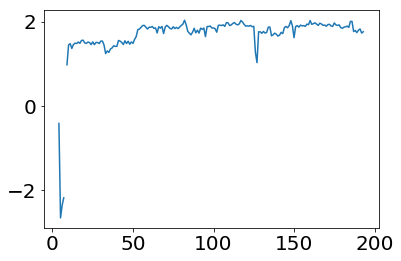

In [10]:
#This is the lowest ratio, but it is because the number of rides near the beginning is 0
pl.plot(np.log10(ridership[np.where(ratio == sortedratio[0])[0][0]]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


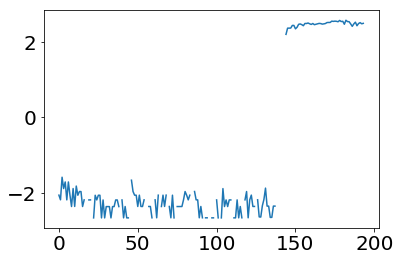

In [11]:
#there is not a constant trend
pl.plot(np.log10(ridership[np.where(ratio == sortedratio[1])[0][0]]))

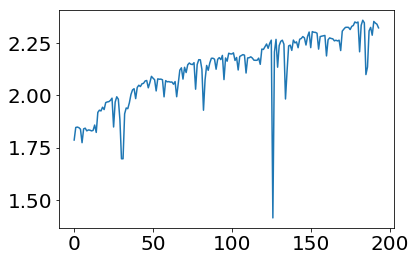

In [12]:
#This ride type has the stepest increase
pl.plot(np.log10(ridership[np.where(ratio == sortedratio[2])[0][0]]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


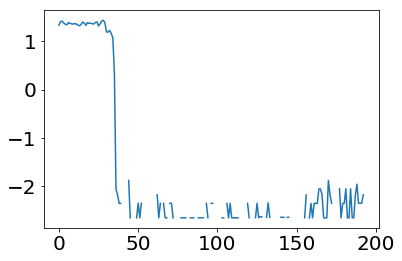

In [13]:
#there is not a constant trend
pl.plot(np.log10(ridership[np.where(ratio == sortedratio[21])[0][0]]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


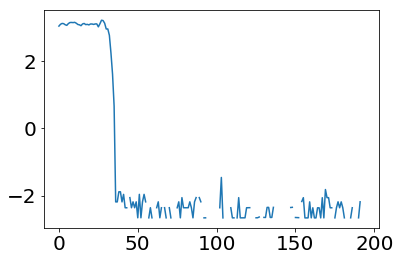

In [14]:
#there is not a constant trend
pl.plot(np.log10(ridership[np.where(ratio == sortedratio[20])[0][0]]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


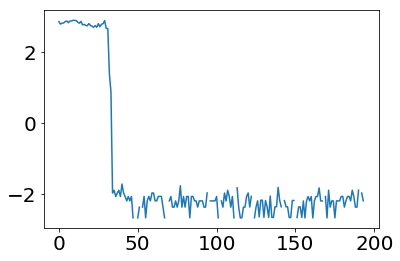

In [15]:
#there is not a constant trend
pl.plot(np.log10(ridership[np.where(ratio == sortedratio[19])[0][0]]))

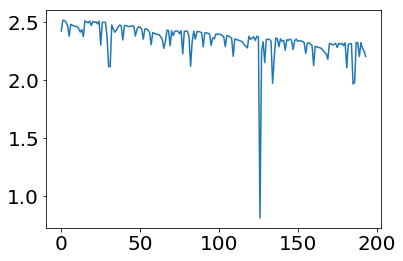

In [16]:
#this ride type has the steepest decrease
pl.plot(np.log10(ridership[np.where(ratio == sortedratio[18])[0][0]]))

In [17]:
#answer
print (ridetype[np.where(ratio == sortedratio[2])[0][0]] + " has the stepest increase")
print (ridetype[np.where(ratio == sortedratio[18])[0][0]] + " has the stepest decrease")

sen has the stepest increase
month has the stepest decrease


# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [18]:
label = np.concatenate([np.array([0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22] * 600)])
label = label[mta.reshape(600*23, 194).std(1) > 0]
label.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(7660,)

In [19]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18,  0,  1,  2,  3,  4,  5,  6,  7])

In [20]:
stationsmeans = np.nanmean(np.nanmean(mta,axis=2),axis=1)
stationsmeans.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(600,)

In [21]:
stationsstd = np.nanstd(np.nanstd(mta,axis=2),axis=1)
stationsstd.shape

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [22]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid = stationid[mta.reshape(600*23, 194).std(1) > 0]
stationid

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([  2,   2,   2, ..., 550, 550, 550])

In [23]:
tots = mta.reshape(600*23, 194)[mta.reshape(600*23, 194).std(1) > 0]
tots.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(7660, 194)

In [24]:
i = 0
normedmta = np.zeros((7660,194))
while i < 7660:
    normedmta[i] = (tots[i] - stationsmeans[stationid[i]]) / stationsstd[stationid[i]]
    i+=1

In [25]:
normed_time_series_mean = np.nanmean(normedmta,axis=1)
normed_time_series_std = np.nanstd(normedmta,axis=1)

In [26]:
normed_time_series_mean.shape

(7660,)

In [27]:
normed_time_series_std[:10]

array([3.13401709, 0.34911948, 0.06515543, 0.07854907, 0.0339129 ,
       2.29172895, 1.46012176, 0.00982369, 0.08901084, 0.53765737])

In [28]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape

(7660,)

In [29]:
tsmean[:10]

array([3.54891753e+03, 1.44587629e+02, 1.79381443e+01, 3.02577320e+01,
       2.89690722e+00, 1.72666495e+03, 1.25873711e+03, 3.86597938e-01,
       4.62886598e+00, 3.00618557e+01])

In [30]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev[:10]


array([391.40042433,  43.60075488,   8.13711673,   9.80981872,
         4.23530701, 286.20893188, 182.35136007,   1.22685827,
        11.1163663 ,  67.14683317])

In [31]:
i = 0
standardizedts = np.zeros((7660,194))
while i < 7660:
    standardizedts[i] = (tots[i] - np.nanmean(tots[i], axis = 0))/np.nanstd(tots[i], axis=0)
    i+=1

Text(0,0.5,'standardized number of rides')

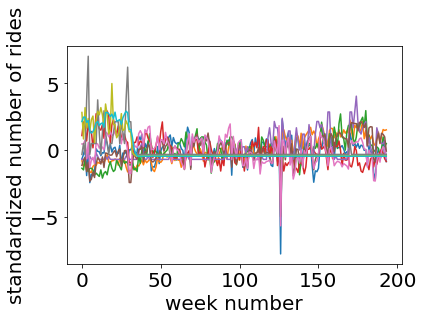

In [32]:
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [33]:
allfits = [sm.OLS(a, sm.add_constant(range(194))).fit() for a in tots]
[a.params[0] for a in allfits[:10]]

[3545.2318794607445,
 81.1603489294211,
 9.239016653449639,
 40.726566217287825,
 -1.4374306106264854,
 1477.2713719270423,
 1363.0342585249805,
 1.3029341792228384,
 16.24155432196669,
 104.1636796193497]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(tots)/normed_time_series_mean, np.std(tots)/normed_time_series_std]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [35]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [36]:
#X_train[~np.isfinite(X_train)] = 0
#X_test[~np.isfinite(X_test)] = 0# ... make a choice about what to do with this datapoint. drop it or replace it with something

In [37]:
#I donot have any missing datapoint
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [38]:
clf = rfc(criterion="gini").fit(X_train, y_train)
y_pred = clf.predict(X_test)

and use sklearn confusion_matrix to see the errors

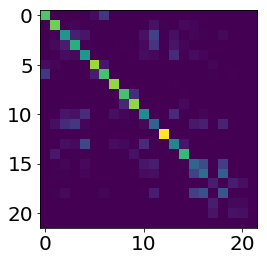

In [39]:
imshow(confusion_matrix(y_test, y_pred))

Figure 1: Shown the model generated some errros, especially for the prediction of last few ridertyoes. The figure indicates that the predicting power of the model is not good, but acceptable. 

In [40]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.79      0.80      0.79       135
        14d       0.82      0.87      0.84       133
         1d       0.58      0.53      0.55       148
         2t       0.63      0.63      0.63       147
        30d       0.53      0.64      0.58       124
         7d       0.88      0.88      0.88       144
        ada       0.76      0.74      0.75       142
       afas       0.91      0.98      0.95       126
        exp       0.81      0.84      0.82       125
         ez       0.83      0.86      0.84       143
         ff       0.58      0.53      0.55       137
         mc       0.33      0.34      0.34       138
         mr       0.99      0.99      0.99       149
      month       0.57      0.47      0.51       146
        rfm       0.81      0.83      0.82       119
         rr       0.39      0.35      0.37       138
        sen       0.37      0.37      0.37       142
       spec       0.32      0.38      0.35   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 and use classification_report to assess the model and clf.feature_importances_ to find the important features

#### According to the classification report, the precision is 0.65 which indicates ,to a certain degree, this is a the model captures many variances and has good predicting power

In [41]:
importances = clf.feature_importances_
importances

array([0.24547708, 0.27664194, 0.21253691, 0.26534406])

Feature ranking:
1. feature 1 (0.276642)
2. feature 3 (0.265344)
3. feature 0 (0.245477)
4. feature 2 (0.212537)


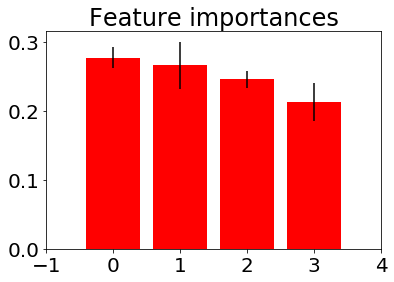

In [42]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
pl.figure()
pl.title("Feature importances")
pl.bar(range(X_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pl.xlim([-1, X_test.shape[1]])

pl.show()

Based on the feature importances analysis, the feature 1 (the slope of the line) and feature 3 (the standard deviation around the data) are the two most important features.

## Build a model that uses as input features each time stamp (194 features) :


In [43]:
# use the same split ratio
#using only the time stamp as features
X_train, X_test, y_train, y_test = train_test_split(tots, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [44]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 194), (2528, 194), (5132,), (2528,))

In [45]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [46]:
# X_train[~np.isfinite(X_train)] = 0
# X_test[~np.isfinite(X_test)] = 0

In [47]:
clf = rfc(criterion="gini").fit(X_train, y_train)
y_pred = clf.predict(X_test)

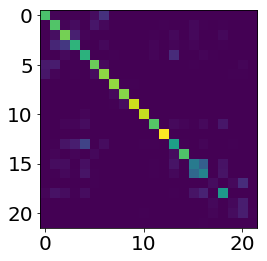

In [48]:
imshow(confusion_matrix(y_test, y_pred))

Figure 2: Shown there are much less errors than the first model, but there are still some errors on the prediction of last few ridertypes.

In [49]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.83      0.79      0.81       135
        14d       0.67      0.81      0.73       133
         1d       0.69      0.79      0.74       148
         2t       0.71      0.65      0.68       147
        30d       0.62      0.77      0.68       124
         7d       0.83      0.80      0.81       144
        ada       0.77      0.87      0.82       142
       afas       0.95      0.98      0.97       126
        exp       0.95      0.97      0.96       125
         ez       0.99      0.96      0.98       143
         ff       0.99      0.99      0.99       137
         mc       0.93      0.79      0.85       138
         mr       0.99      0.99      0.99       149
      month       0.66      0.58      0.61       146
        rfm       0.96      0.90      0.93       119
         rr       0.47      0.44      0.46       138
        sen       0.49      0.46      0.48       142
       spec       0.45      0.17      0.25   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))


#### The prediction power of the model increased a lot if we use all the time stamp as features (194 features), but ther is a risk of overfitting.

In [50]:
importances = clf.feature_importances_
importances

array([0.0051092 , 0.00838846, 0.00900668, 0.00844317, 0.00920931,
       0.00487977, 0.01586609, 0.00753237, 0.00682785, 0.0098351 ,
       0.01312924, 0.01322468, 0.00409362, 0.00769503, 0.00463167,
       0.00854438, 0.00442741, 0.01183397, 0.01231723, 0.00831688,
       0.00500812, 0.0053746 , 0.00436722, 0.00483336, 0.01255495,
       0.00737353, 0.00335127, 0.00796707, 0.00557358, 0.0140915 ,
       0.00657401, 0.01100993, 0.02099854, 0.01637846, 0.01695179,
       0.01420693, 0.00255589, 0.01389111, 0.00253611, 0.01174708,
       0.00450086, 0.00302878, 0.00875851, 0.00808864, 0.01704746,
       0.00649252, 0.00228437, 0.00259405, 0.00348037, 0.00330044,
       0.0068517 , 0.00271123, 0.00725679, 0.00172798, 0.00251714,
       0.00193421, 0.00334954, 0.00103454, 0.00144849, 0.00211098,
       0.00205011, 0.0073079 , 0.00703069, 0.00194373, 0.00148062,
       0.00300199, 0.00833881, 0.00113623, 0.0063023 , 0.00196976,
       0.00241771, 0.00145466, 0.00152494, 0.00307179, 0.00309

In [52]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(3):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 79 (0.021920)
2. feature 32 (0.020999)
3. feature 44 (0.017047)


The 79 weeks and 32 weeks are the two most important features.